<a href="https://colab.research.google.com/github/Thrcordeiro/LojasRossmann/blob/main/Rossmann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão Lojas Rossmann

Objetivo: Preveer as vendas das próximas 4 semanas das Lojas Rossmann

# 0.0.IMPORTS

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import math
import pandas as pd
import numpy as np
import inflection
import seaborn as sns
import matplotlib.pyplot as plt

import stats

from scipy import stats

## 0.1. Função Auxiliar

In [ ]:
#Teste baseado em Pearson, para ver a correlação Multivariada das variáveis categóricas
def cramer_v(x,y):
    cm = pd.crosstab(x,y).to_numpy()
    # Soma de tds os valores
    n = cm.sum()
    #Número de linhas e colunas
    r, k = cm.shape

    chi2 = stats.chi2_contingency(cm)[0]
    #Aplicando a correção de bies do cramer-v
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)

    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))

## 0.2. Carregando Dados

In [ ]:
df_vendas = pd.read_csv('train.csv')
df_store = pd.read_csv('store.csv')

In [ ]:
df = pd.merge(df_vendas, df_store, how='left', on='Store')

In [ ]:
df.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

In [ ]:
df['date'].min()

Timestamp('2013-01-01 00:00:00')

In [ ]:
df['date'].max()

Timestamp('2015-07-31 00:00:00')

# 1.0. DESCRIÇÃO DOS DADOS

In [ ]:
df.sample(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
399492,504,4,2014-07-10,5022,827,1,0,0,0,c,c,820.0,NaN,NaN,0,NaN,NaN,NaN
55568,934,5,2015-06-12,7043,715,1,0,0,0,a,c,5460.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
128924,700,2,2015-04-07,4459,590,1,0,0,1,a,c,830.0,NaN,NaN,1,27.0,2013.0,"Jan,Apr,Jul,Oct"


In [ ]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1. Renomear colunas

In [ ]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday',
            'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
            'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))
df.columns = cols_new

## 1.2. Dimensão Dataset

In [ ]:
print('Numero de filas:{}'.format(df.shape[0]))
print('Numero de colunas:{}'.format(df.shape[1]))

Numero de filas:1017209
Numero de colunas:18


## 1.3. Tipo de Dados

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Modificando Tipos

In [ ]:
#df['competition_open_since_month'] =

## 1.5. Check NA

In [ ]:
df.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## Preenchendo Vazios

In [ ]:
df['competition_distance'] = df['competition_distance'].apply(lambda x:200000.0 if math.isnan(x) else x)

## 1.5. Descrição Estatística

In [ ]:
df1 = df.copy()
df1= df1.query('sales>=0') # Regra de Negócio: Vendas não podem ser negativas

In [ ]:
num_atributos = df.select_dtypes(include=['int64','float64', 'int32'])

cat_atributos = df.select_dtypes(exclude=['int64','float64', 'int32'])

### 1.5.1. Atributos Numéricos

In [ ]:
num_atributos.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year
count,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,693861.00,693861.00,1017209.00,509178.00,509178.00
mean,558.43,4.00,5773.82,633.15,0.83,0.38,0.18,5935.44,7.22,2008.69,0.50,23.27,2011.75
std,321.91,2.00,3849.93,464.41,0.38,0.49,0.38,12547.65,3.21,5.99,0.50,14.10,1.66
min,1.00,1.00,0.00,0.00,0.00,0.00,0.00,20.00,1.00,1900.00,0.00,1.00,2009.00
25%,280.00,2.00,3727.00,405.00,1.00,0.00,0.00,710.00,4.00,2006.00,0.00,13.00,2011.00
50%,558.00,4.00,5744.00,609.00,1.00,0.00,0.00,2330.00,8.00,2010.00,1.00,22.00,2012.00
75%,838.00,6.00,7856.00,837.00,1.00,1.00,0.00,6910.00,10.00,2013.00,1.00,37.00,2013.00
max,1115.00,7.00,41551.00,7388.00,1.00,1.00,1.00,200000.00,12.00,2015.00,1.00,50.00,2015.00


### 1.5.2. Atributos Categoricos

In [ ]:
cat_atributos.apply(lambda x:x.unique().shape[0])

date              942
state_holiday       5
store_type          4
assortment          3
promo_interval      4
dtype: int64

In [ ]:
df1['state_holiday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [ ]:
aux1 = df1[(df1['state_holiday']!='0') & (df1['state_holiday']!=0) & (df1['sales']>0)]

<Axes: xlabel='assortment', ylabel='sales'>

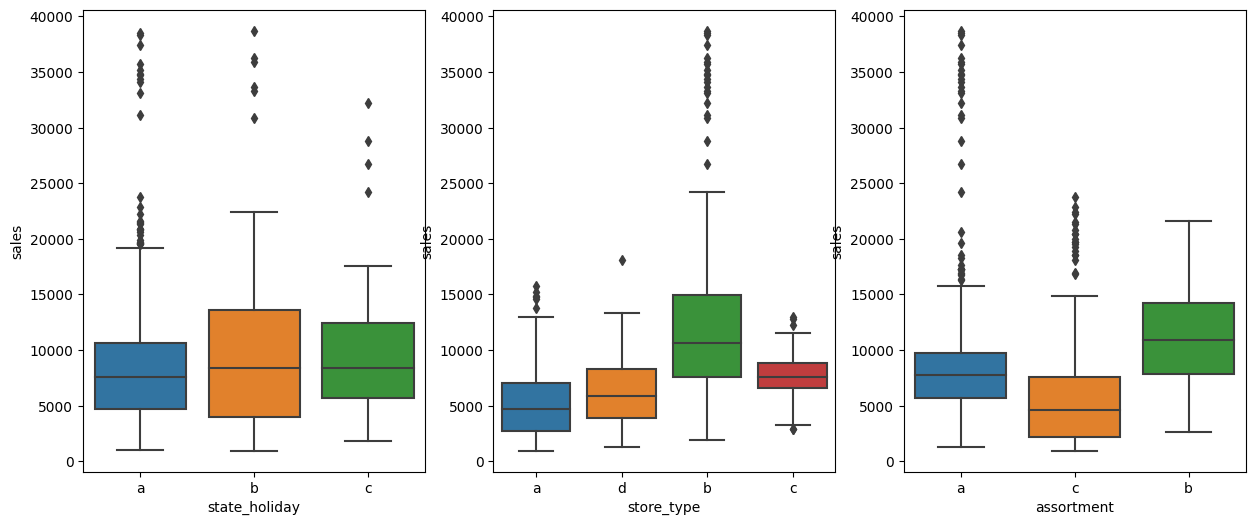

In [ ]:
fig = plt.figure(figsize =(15, 6))

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux1)

# 2.0. ENGENHARIA DE FEATURES

In [ ]:
df2 = df1.copy()
df2.drop(['competition_open_since_month', 'competition_open_since_year','promo2_since_week','promo2_since_year','promo_interval'], axis=1, inplace=True)

## 2.1. Hipoteses

H1. Lojas com maior sortimento deveriam vender mais <br>
H2. Lojas com competidores mais próximos deveriam vender menos <br>
H3. Lojas com mais promoções consecutivas deveriam vender mais <br>
H4. Lojas abertas durante o peridodo de natal deveriam vender mais <br>
H5. Lojas deveriam vender mais ao longo dos anos <br>
H6. Lojas devem vender mais no segundo semestre do ano. <br>  
H7. Lojas deveriam vender mais depois do dia 10 de cada mês <br>
H8. Lojas deveriam vender mais nos finais de semana <br>

### 2.2. Engenharia de Features

In [ ]:
df2.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'promo2'],
      dtype='object')

In [ ]:
# Ano
df2['year'] = df2['date'].dt.year
# Mes
df2['month'] = df2['date'].dt.month
# Dia
df2['day'] = df2['date'].dt.day
# ano semana
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#assortments
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')
#state holidays
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

# 3.0. FILTRAGEM DE VARIAVEIS

In [ ]:
df3 = df2.copy()

### 3.1. Filtragem de Linhas

In [ ]:
df3 = df3[(df3['open']!=0) & (df3['sales']>0)]

### 3.2. Seleção de Colunas

In [ ]:
# Removendo colunas
cols_drop = ['customers', 'open']
df3 = df3.drop(cols_drop, axis=1)

In [ ]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'promo2', 'year', 'month', 'day', 'year_week'],
      dtype='object')

# 4.0. ANALISE EXPLORATORIA DADOS

In [ ]:
df4 = df3.copy()

## 4.1. Analise Univariada

<Axes: xlabel='sales', ylabel='Density'>

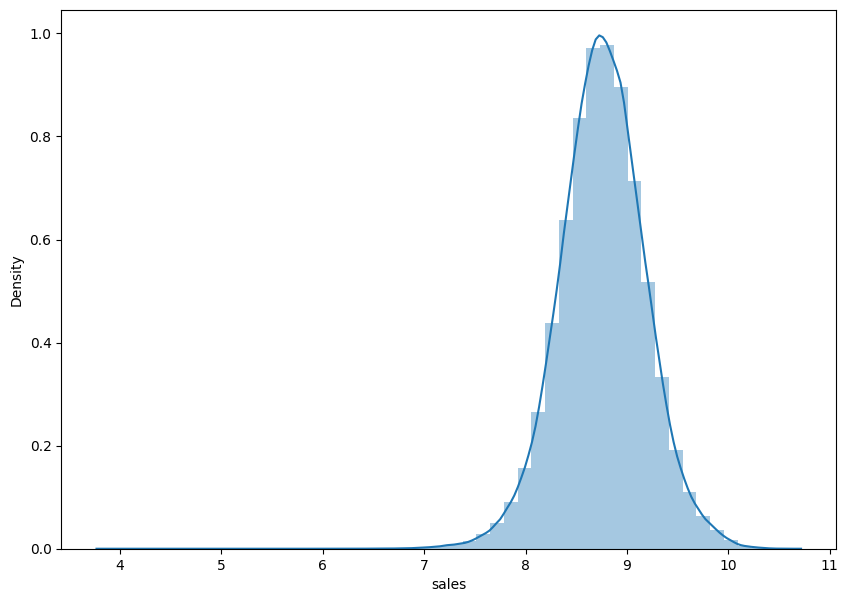

In [ ]:
fig = plt.figure(figsize=(10,7))
sns.distplot(np.log1p(df4['sales']))

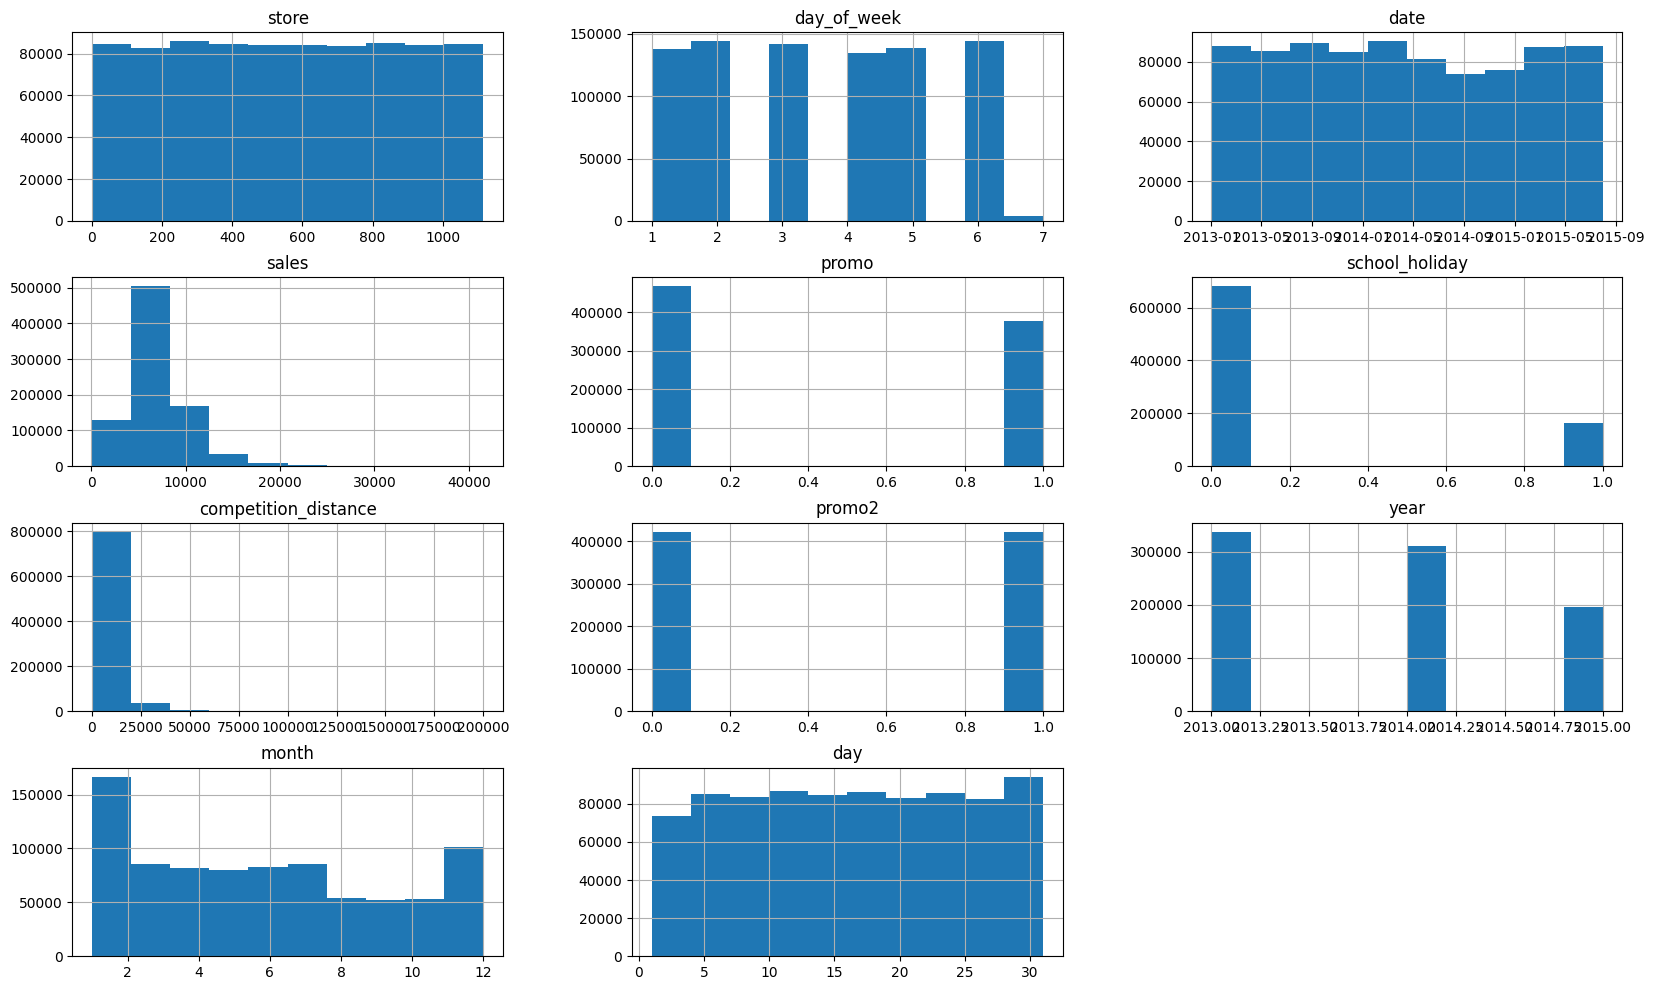

In [ ]:
df4.hist(figsize=(20,12));

## 4.2. Analise Bivariada

#### H1. Lojas com maior sortimento deveriam vender mais

FALSO: Lojas com maior sortimento vendem menos.

<Axes: xlabel='year_week'>

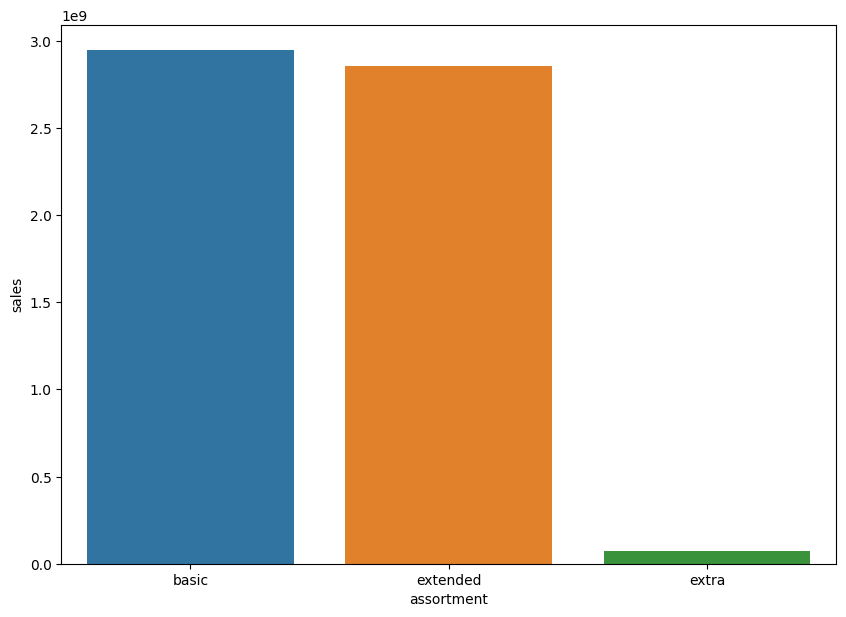

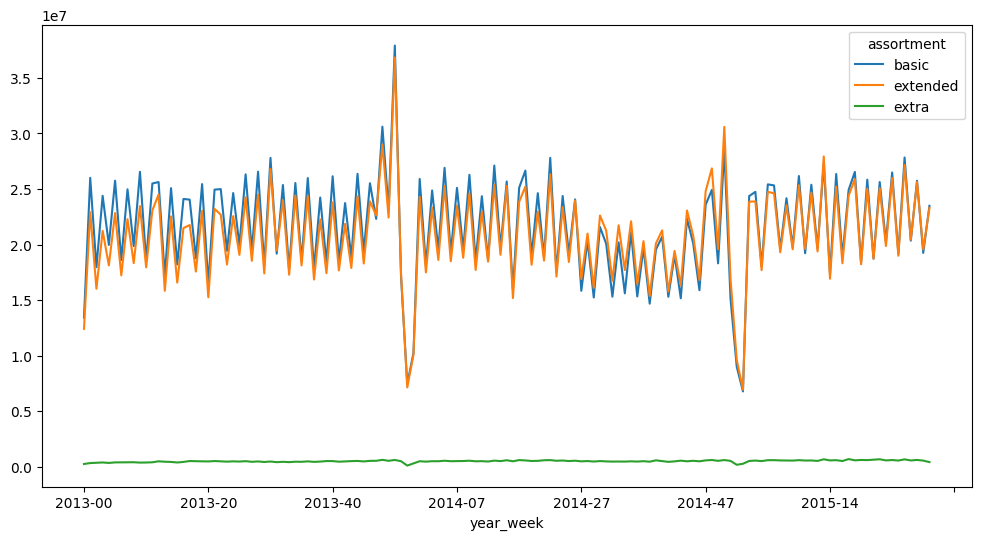

In [ ]:
fig = plt.figure(figsize =(10, 7))

aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment',y='sales',data=aux1);

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week',columns='assortment',values='sales').plot(figsize =(12, 6))

#### H2. Lojas com competidores mais próximos deveriam vender menos

FALSO: Lojas com competidores mais próximos vendem mais.

In [ ]:
fig = plt.figure(figsize =(21, 10))
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

<Figure size 2100x1000 with 0 Axes>

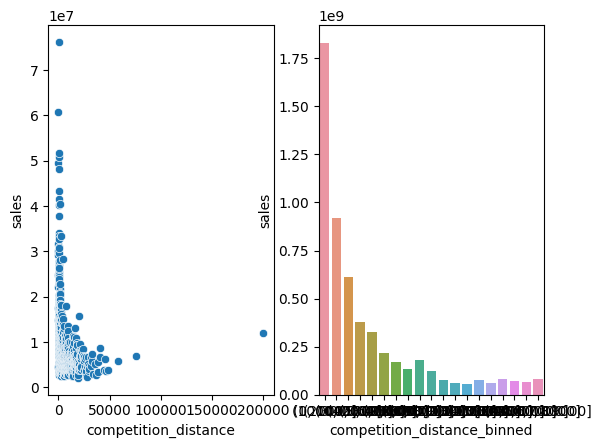

In [ ]:
plt.subplot(1,2,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1,2,2)
bins = list(np.arange(0,20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales',data=aux2);

#### H3. Lojas com mais promoções consecutivas deveriam vender mais

Falso: Lojas com promoções consecutivas vendem menos

In [ ]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


#### H4. Lojas abertas durante o peridodo de natal deveriam vender mais

**Falso.** Nas férias de natal se vende menos.
Mas, devemos considerar que no dataset só temos dados até julio do 2015.

In [ ]:
df_natal = df4.query('year!= 2015')

<Axes: xlabel='year', ylabel='sales'>

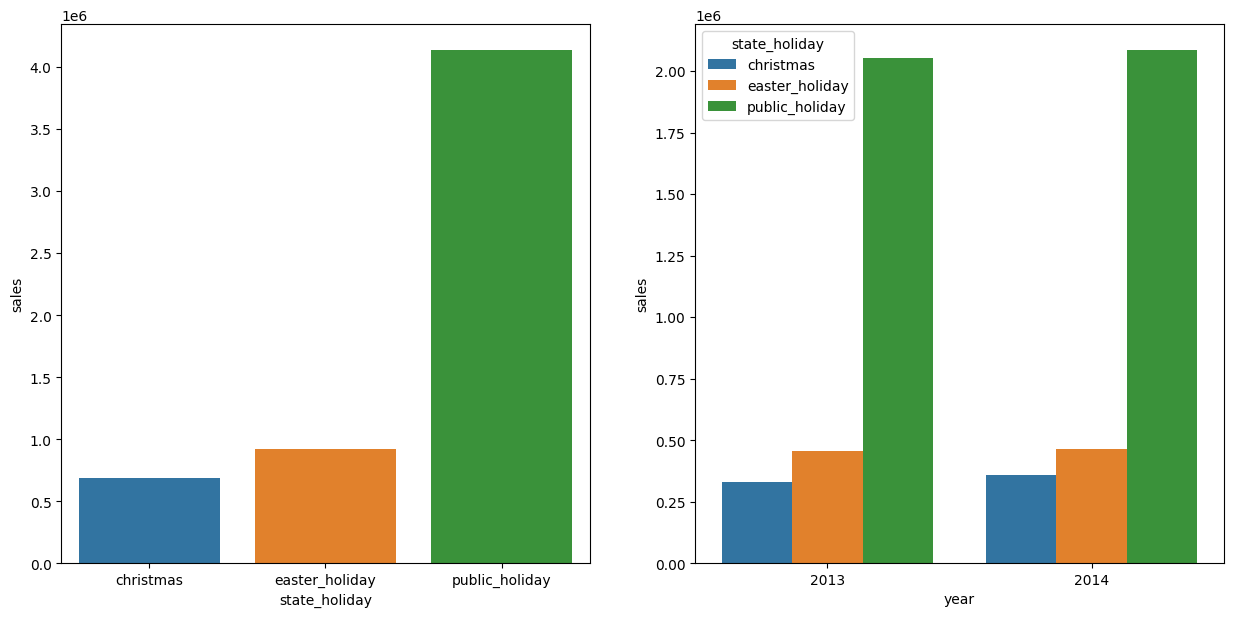

In [ ]:
aux_natal = df_natal[df_natal['state_holiday'] != 'regular_day']
fig = plt.figure(figsize =(15, 7))

plt.subplot(1,2,1)
aux1s = aux_natal[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data = aux1s)

plt.subplot(1,2,2)
aux2s = aux_natal[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales',hue='state_holiday', data = aux2s)

#### H5. Lojas deveriam vender mais ao longo dos anos

Falso. Lojas estão vendendo menos ao longo dos anos. Mas, vale considerar que não temos dados do fim do ano 2015

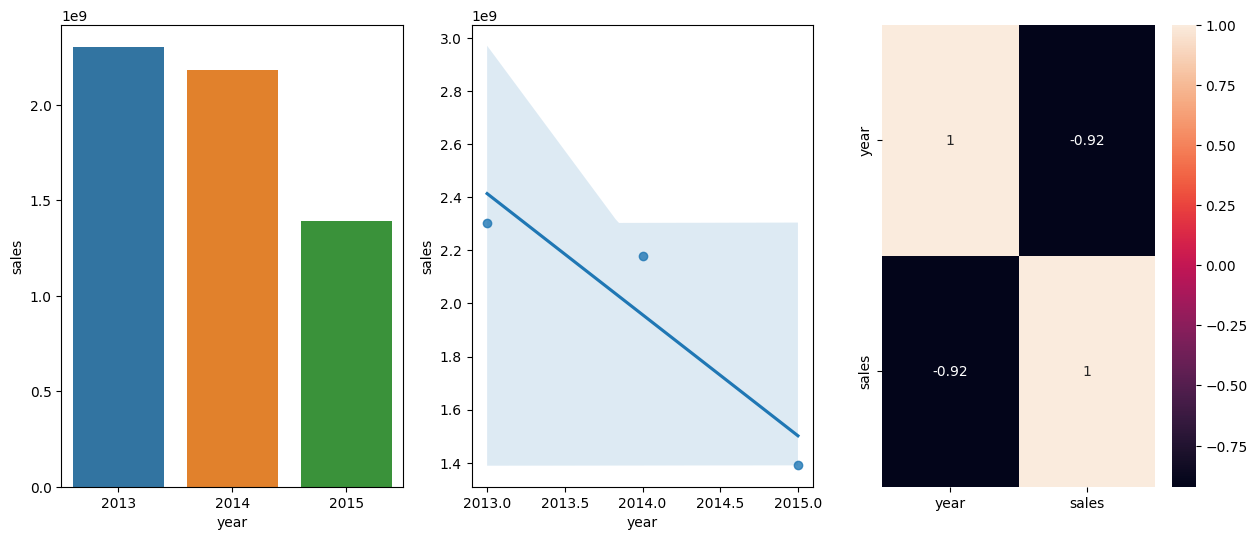

In [ ]:
fig = plt.figure(figsize =(15, 6))

plt.subplot(1,3,1)
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()
sns.barplot(x='year' , y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

#### H6. Lojas devem vender mais no segundo semestre do ano.

Verdadeiro. Lojas vendem mais no segundo semestre. Mas, tiramos dados do 2015 pq eles não tem o segundo semestre do ano.

In [ ]:
df_aux = df4.query('year!= 2015')

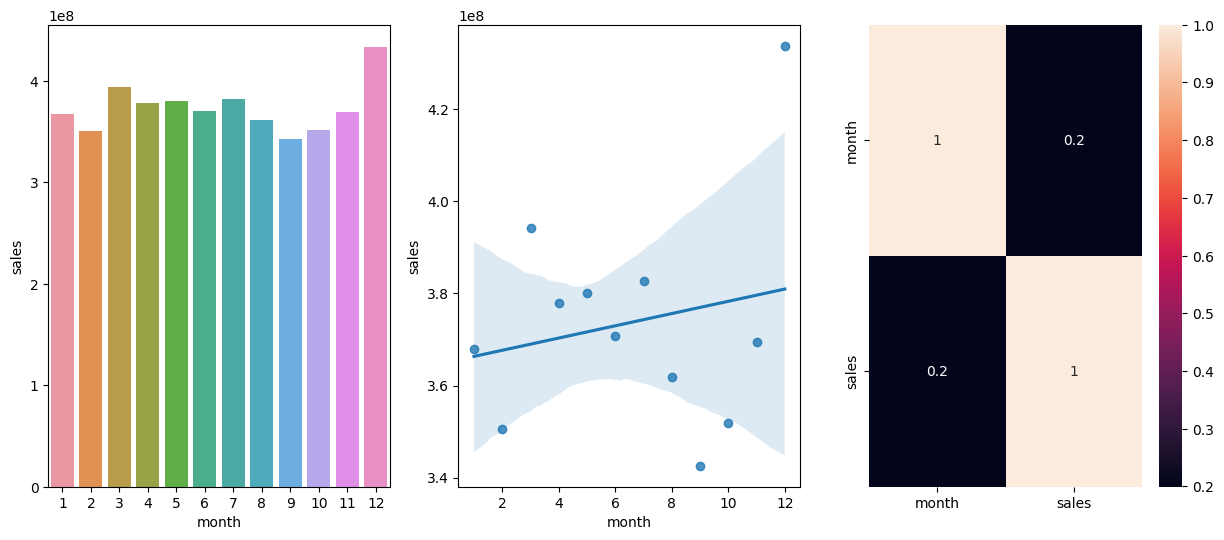

In [ ]:
fig = plt.figure(figsize =(15, 6))

plt.subplot(1,3,1)
aux1x=df_aux[['month','sales']].groupby('month').sum().reset_index()
sns.barplot(x='month',y='sales',data=aux1x);

plt.subplot(1,3,2)
sns.regplot(x='month',y='sales',data=aux1x);

plt.subplot(1,3,3)
sns.heatmap(aux1x.corr(method='pearson'),annot=True);

#### H7. Lojas deveriam vender mais nos finais de semana

Falso. Lojas vendem menos nos finais de semana

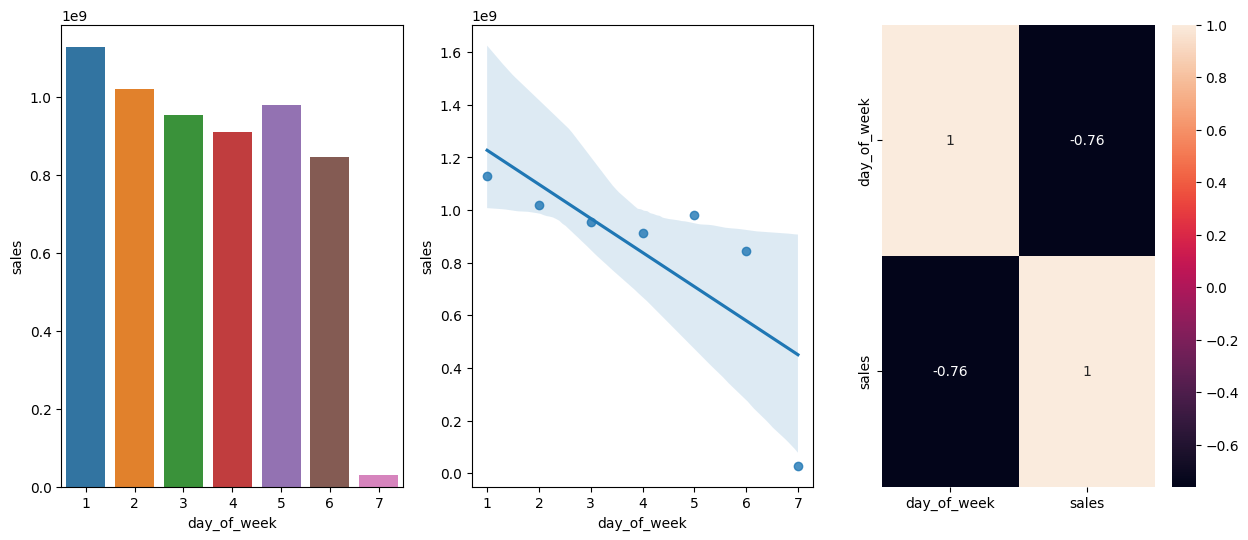

In [ ]:
ig = plt.figure(figsize =(15, 6))
plt.subplot(1,3,1)
aux1=df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week',y='sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

## 4.3. Analise Multivariada

In [ ]:
num_attributes = df4.select_dtypes(include=['int64','float64','int32'])
cat_attributes = df4.select_dtypes(exclude=['int64','float64','datetime64[ns]','int32'])

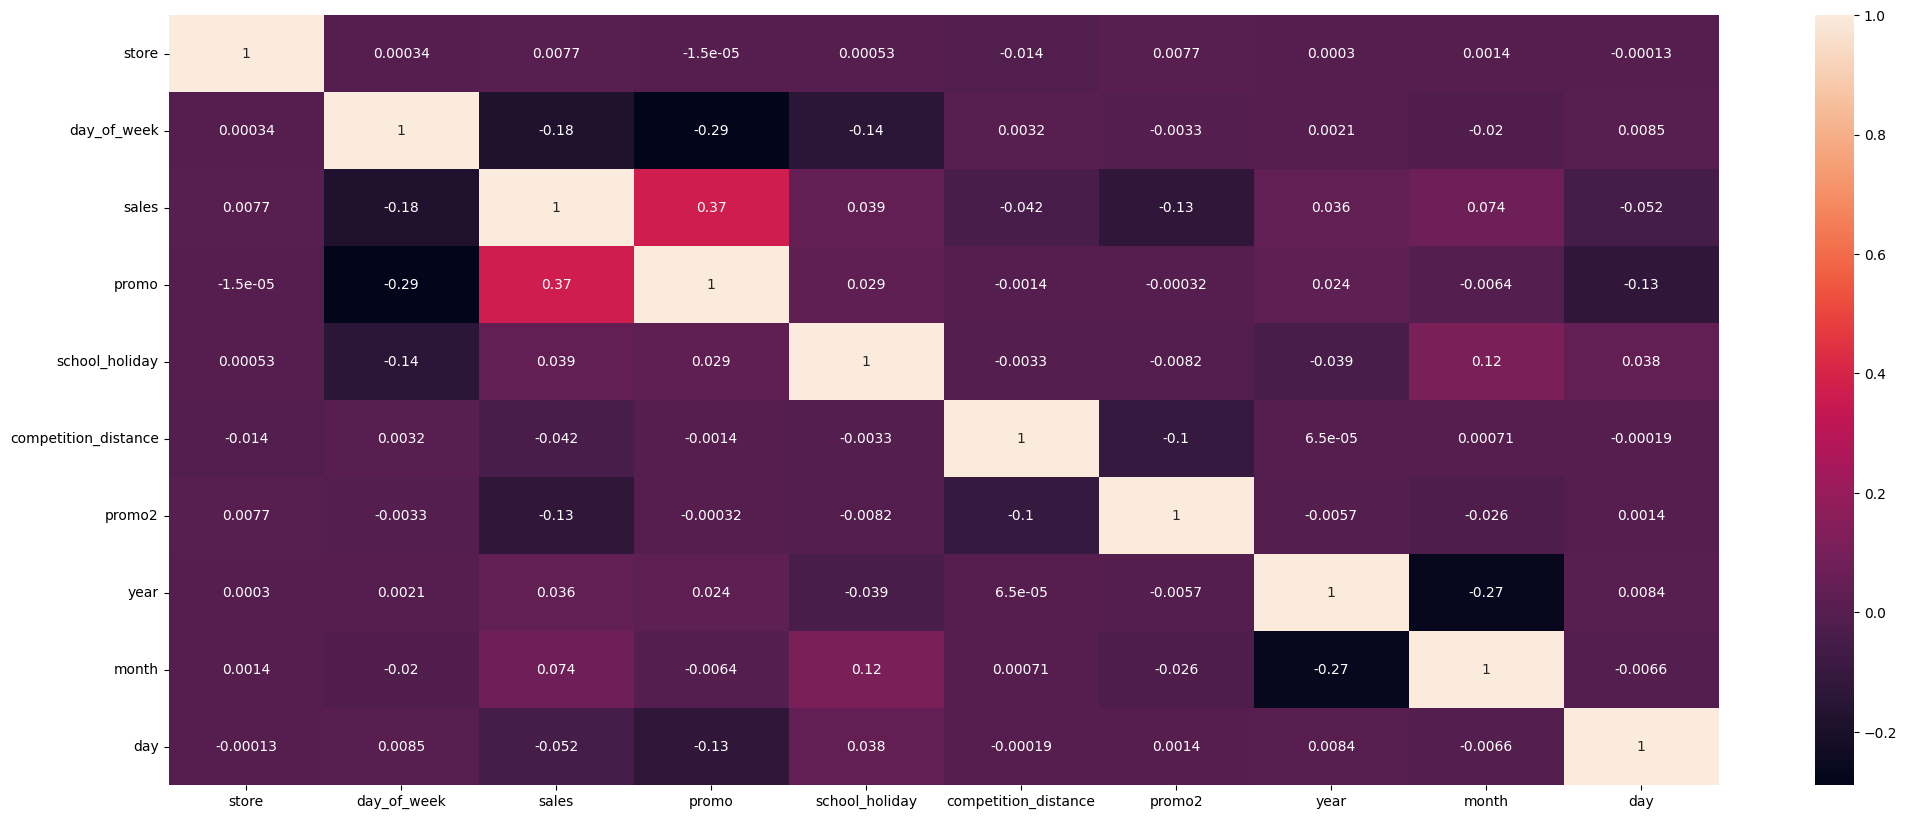

In [ ]:
fig = plt.figure(figsize =(25, 10))

correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

In [ ]:
a = df4.select_dtypes(include='object')
a.sample(10)

,state_holiday,store_type,assortment,year_week
40619,regular_day,a,basic,2015-25
295692,regular_day,a,extended,2014-43
135063,regular_day,d,basic,2015-13
971004,regular_day,a,basic,2013-06
681181,regular_day,a,basic,2013-43
944560,regular_day,a,basic,2013-09
606119,regular_day,a,basic,2014-00
410994,regular_day,a,basic,2014-25
757811,regular_day,a,extended,2013-33
590186,regular_day,a,basic,2014-02


In [ ]:
#Chamando a função

a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])

d = pd.DataFrame({'state_holiday':[a1,a2,a3],
              'store_type':[a4,a5,a6],
              'assortment':[a7,a8,a9],
             })

d = d.set_index(d.columns)

<Axes: >

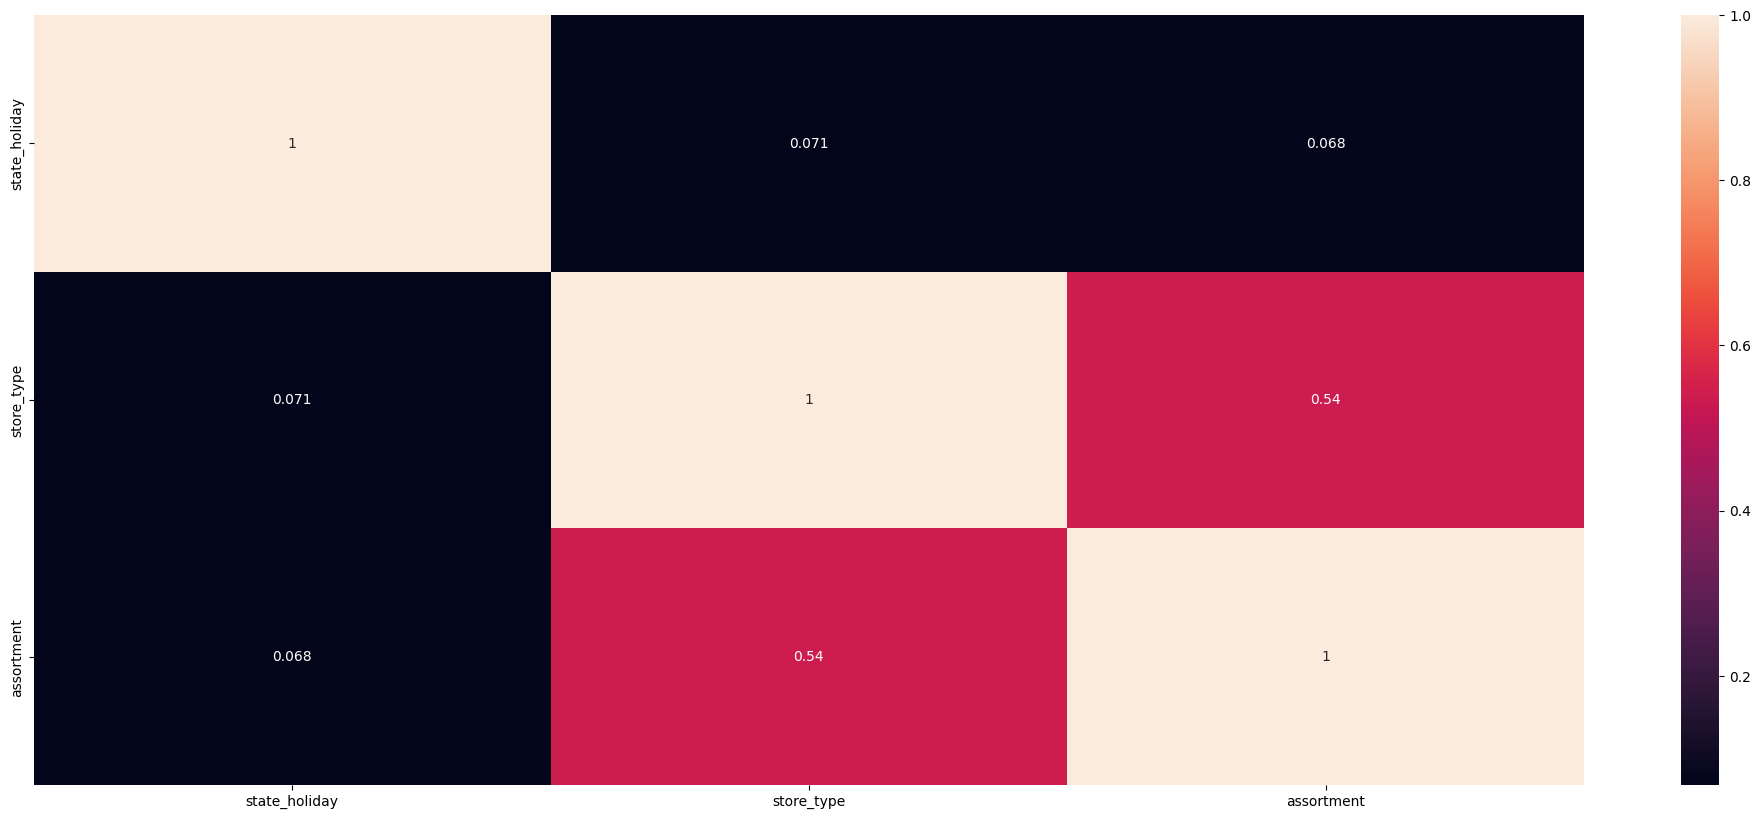

In [ ]:
fig = plt.figure(figsize =(25, 10))
sns.heatmap(d,annot=True)